In [1]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.circuit.library import QFT, GroverOperator

from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory

import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
evaluation_qubits = 4

probability = 0.3
theta = 2 * np.arcsin(np.sqrt(probability))

evaluation_registry = QuantumRegister(evaluation_qubits, 'evaluation')
a_registry = QuantumRegister(1, 'q')

## First with the Qiskit function

In [3]:
a_factory =  QuantumCircuit(a_registry)
a_factory.ry(theta, a_registry[0])
backend = Aer.get_backend('statevector_simulator')
job = execute(a_factory, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

{'0': 0.7, '1': 0.3}


In [4]:
ae = AmplitudeEstimation(evaluation_qubits, a_factory)
ae_result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'))

In [5]:
ae_result

{'a_estimation': 0.3086583, 'confidence_interval': [0.29753558077027575, 0.3203806747402484], 'estimation': 0.3086583, 'num_oracle_queries': 15360, 'ml_value': 0.3170880793520352, 'mapped_a_samples': [0.0, 0.1464466, 0.3086583, 0.5, 0.8535534], 'probabilities': [0.0009765625, 0.0009765625, 0.9931640625, 0.0029296875, 0.001953125], 'shots': 1024, 'mle': 0.3170880793520352, 'circuit_result': {'0000': 1, '0011': 3, '0101': 1, '0110': 1, '0111': 1, '1011': 526, '1100': 491}, 'a_samples': [(0.0, 0.0009765625), (0.1464466, 0.0009765625), (0.3086583, 0.9931640625), (0.5, 0.0029296875), (0.8535534, 0.001953125)], 'y_measurements': [(0, 0.0009765625), (3, 0.4794921875), (6, 0.0009765625), (10, 0.0009765625), (12, 0.0029296875), (13, 0.513671875), (14, 0.0009765625)], 'mapped_values': [0.0, 0.1464466, 0.3086583, 0.5, 0.8535534], 'max_probability': 0.9931640625}

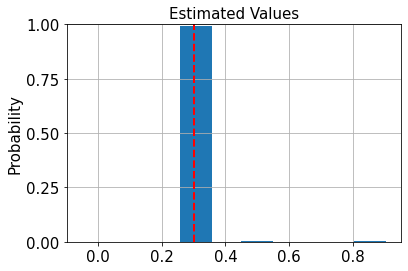

In [6]:
# plot estimated values
plt.bar(ae_result['mapped_a_samples'], ae_result['probabilities'], width=0.5/len(ae_result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

In [7]:
ae._circuit.draw()

┌───┐     ┌─────────┐                                 ┌──────┐┌─┐»
eval_0: ────┤ H ├─────┤0        ├─────────────────────────────────┤0     ├┤M├»
            ├───┤     │         │┌─────────┐                      │      │└╥┘»
eval_1: ────┤ H ├─────┤         ├┤0        ├──────────────────────┤1     ├─╫─»
            ├───┤     │         ││         │┌─────────┐           │  qft │ ║ »
eval_2: ────┤ H ├─────┤  c_Q**1 ├┤         ├┤0        ├───────────┤2     ├─╫─»
            ├───┤     │         ││  c_Q**2 ││         │┌─────────┐│      │ ║ »
eval_3: ────┤ H ├─────┤         ├┤         ├┤  c_Q**4 ├┤0        ├┤3     ├─╫─»
        ┌───┴───┴────┐│         ││         ││         ││  c_Q**8 │└──────┘ ║ »
   q_0: ┤ RY(1.1593) ├┤1        ├┤1        ├┤1        ├┤1        ├─────────╫─»
        └────────────┘└─────────┘└─────────┘└─────────┘└─────────┘         ║ »
  c0: 4/═══════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«                 
«eval_0: ─────────
«        ┌─┐      
«eval_1: ┤M├──────
«        └╥┘┌─┐   
«eval_2: ─╫─┤M├───
«         ║ └╥┘┌─┐
«eval_3: ─╫──╫─┤M├
«         ║  ║ └╥┘
«   q_0: ─╫──╫──╫─
«         ║  ║  ║ 
«  c0: 4/═╩══╩══╩═
«         1  2  3

Q Operator

$$ \mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f, $$

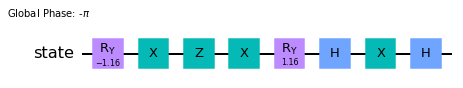

In [8]:
test_gate = ae.grover_operator.inverse().to_gate().control(1)
ae.grover_operator.inverse().draw('mpl')

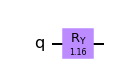

In [9]:
ae.state_preparation.draw('mpl')

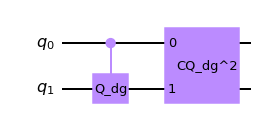

In [10]:
q_test = QuantumCircuit(2)
q_test.append(test_gate, [0,1])
q_test.append(test_gate.power(2), [0,1])
q_test.draw('mpl')

## Design our own AE

In [11]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)



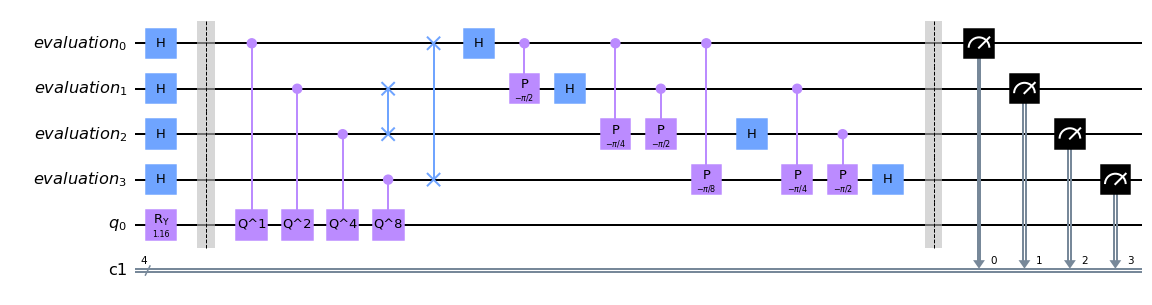

In [12]:
cr = ClassicalRegister(evaluation_qubits)
qc = QuantumCircuit(evaluation_registry, a_registry, cr)

#qc.append(a_operator(), a_registry)

# A
qc.ry(theta, a_registry)

qc.h(range(evaluation_qubits))
qc.barrier()
#Do the controlled-U operations:
# 𝑄=𝐴𝑆0𝐴−1𝑆𝜓0
repetitions = 1
for counting_qubit in range(evaluation_qubits):
    
    q_op = QuantumCircuit(1)
    
    # Spsi
    q_op.x(0)
    q_op.z(0)
    q_op.x(0)

    # A
    q_op.ry(-theta*repetitions, 0)
    
    # S0
    q_op.x(0)
    q_op.z(0)
    q_op.x(0)
    
    # A
    q_op.ry(theta*repetitions, 0)
    
    label = "Q^"+str(repetitions)
    
    qc.append(q_op.to_gate(label=label).control(1), [counting_qubit, evaluation_qubits])
    repetitions *= 2
    
qft_dagger(qc, evaluation_qubits)
#qc.append(QFT(evaluation_qubits, inverse=True, do_swaps=False), range(evaluation_qubits))
qc.barrier()
qc.measure(range(evaluation_qubits), cr)
qc.draw('mpl')

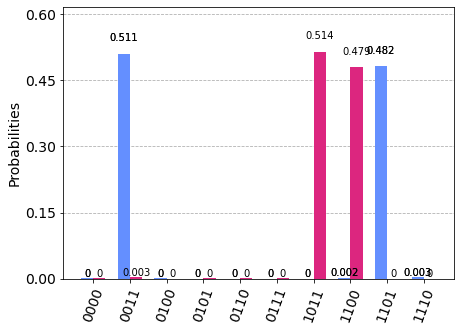

In [13]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()

plot_histogram([counts, ae_result['circuit_result']])

In [15]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider()
#backend_real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > evaluation_qubits+1 and not x.configuration().simulator ))
#backend_real.name()
backend_real = "ibmq_manila"

job_real = execute(qc, backend=backend_real, shots=1024)
job_monitor(job_real)
results_real = job_real.result()

ibmqfactory.load_account:WARNING:2022-02-17 11:36:27,303: Credentials are already in use. The existing account in the session will be replaced.


AttributeError: 'str' object has no attribute 'properties'

In [ ]:
backend_real.name()

In [ ]:
results_real = job_real.result()
counts_real = results_real.get_counts()

In [ ]:
from kaleidoscope import probability_distribution

probability_distribution([counts, ae_result['circuit_result'], counts_real], legend=['Sim Manual', 'Sim Qiskit Aqua', backend_real.name()], figsize=(1024,600))

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram([counts,counts_real])

In [ ]:
print(ae_result['circuit_result'])
print(counts)

In [ ]:
# REason for decoherence and noise?
#transpiled_circuit = qc.transpiled_circuit
from qiskit import transpile
qc_transpiled = transpile(qc, backend_real , optimization_level=3)

In [ ]:
print(qc_transpiled.depth())
print(qc_transpiled.size())

In [ ]:
# TODO: Wrong calculation
plt.plot(counts.values())
# Real (Red)
plt.plot([probability * 2**evaluation_qubits, probability * 2**evaluation_qubits], [0,max(counts.values())], 'r--', linewidth=2)
# Calculated (Green)
plt.plot([int(max(counts, key=counts.get),2), int(max(counts, key=counts.get),2)], [0,max(counts.values())], 'g--', linewidth=2)
plt.show()

In [ ]:
# TODO: This is not correct

print("Most probably state: ", max(counts, key=counts.get), "-- ", int(max(counts, key=counts.get),2))
estimated_probability = int(max(counts, key=counts.get),2) / 2**evaluation_qubits
print("Estimated Probability: theta = state / 2^n :", estimated_probability)
print("Real Probability: ", probability)
print("Error: ", estimated_probability - probability)

#theta = 2 * np.arcsin(np.sqrt(probability))

# a = sin2 (θ) (approx)
print(theta)
print((np.sin(estimated_probability/2))**2)

In [ ]:
for i in counts:
    estimated_probability = int(i,2) / 2**evaluation_qubits
    print(i, " : ", counts[i], " - ", estimated_probability)

Grover operator examples

In [ ]:
oracle = QuantumCircuit(4)
oracle.z(3)
reflection_qubits = [0, 3]
state_preparation = QuantumCircuit(4)
state_preparation.ry(0.3, 3)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=reflection_qubits, insert_barriers=True)
grover_op.draw('mpl')

In [ ]:
state_preparation = QuantumCircuit(3)

oracle = QuantumCircuit(3)
oracle.x([2,0])
oracle.h(2)
oracle.mcx([2],0)
oracle.h(2)
oracle.x([2,0])

zero_reflection = QuantumCircuit(3)
zero_reflection.cry(0.3, 0, 2)

state_preparation.ry(0.3, 2)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=[0,3], zero_reflection=zero_reflection)
grover_op.draw('mpl')

In [ ]:
    state_preparation = QuantumCircuit(evaluation_qubits+1)
    oracle = QuantumCircuit(evaluation_qubits+1)
    oracle.x(evaluation_qubits)
    oracle.z(evaluation_qubits)
    oracle.x(evaluation_qubits)
    state_preparation.ry(theta*repetitions, evaluation_qubits)
    grover_op = GroverOperator(oracle, state_preparation)
    grover_op.draw()

## Next steps

Clearly with "standard" QAE out of the box, even if we could optimize the circuit, we won't go far on current NISQ computers. Circuit depth is too big to get any decent result.

Let's try with IAE

In [ ]:
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation

epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(state_preparation=a_factory,
                                  epsilon=epsilon, alpha=alpha)
iae_result = iae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=1000)

In [ ]:
print(iae_result)

print("Estimation: ", iae_result['estimation'])
print("Real probability: ", probability)

In [ ]:
## Run IAE on a real device

IBMQ.load_account()
provider = IBMQ.get_provider()
backend_real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 1 and not x.configuration().simulator ))
backend_real.name()
iae_real_result = iae.run(quantum_instance=backend_real, shots=1000)


In [ ]:
iae_real_result